In [1]:
# Cell 1: 라이브러리 임포트 및 초기 설정
import os
import json
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# est_utils.py에서 필요한 함수 및 상수 임포트
from est_utils import (
    create_soft_label,
    correct_image_orientation,
    BACKBONE_CLASSES,
    FONT_PROP,
    EST_DATA_BASE_DIR,
    LABEL_FOLDERS,
    LABEL_TARGETS
)

# 이미지 디렉토리 설정 (est_utils.py의 EST_DATA_BASE_DIR 기반)
img_dirs = {
    'train': os.path.join(EST_DATA_BASE_DIR, 'img_train'),
    'val': os.path.join(EST_DATA_BASE_DIR, 'img_val'),
    'test': os.path.join(EST_DATA_BASE_DIR, 'img_test')
}

In [2]:
# Cell 2: annotation_to_backbone_map 로드 (JSON 파일에서)
import json

# 사용할 매핑 버전 선택
# config_file = "configs/soft_label_map_v1.json"
config_file = "configs/soft_label_map_v2.json" 

try:
    with open(config_file, 'r', encoding='utf-8') as f:
        annotation_to_backbone_map = json.load(f)
    print(f"Loaded annotation_to_backbone_map from {config_file}")
except FileNotFoundError:
    print(f"Error: Configuration file not found at {config_file}. Please check the path.")
    annotation_to_backbone_map = {} # Fallback to empty map or handle error appropriately
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {config_file}. Please check file format.")
    annotation_to_backbone_map = {}
except Exception as e:
    print(f"An unexpected error occurred while loading {config_file}: {e}")
    annotation_to_backbone_map = {}

# 로드된 매핑 확인 (선택 사항)
print(annotation_to_backbone_map)

Loaded annotation_to_backbone_map from configs/soft_label_map_v2.json
{'기쁨': {'happy': 1.0}, '당황': {'fear': 0.3, 'surprise': 0.5, 'neutral': 0.2}, '분노': {'anger': 0.8, 'neutral': 0.2}, '불안': {'fear': 1.0}, '상처': {'sad': 0.7, 'neutral': 0.3}, '슬픔': {'sad': 0.7, 'neutral': 0.3}, '중립': {'neutral': 1.0}}


In [3]:
# Cell 3: 메인 데이터 처리 함수 정의 (load_and_process_data)
def load_and_process_data(
    base_dir,
    label_folders,
    img_dirs,
    label_targets,
    backbone_classes,
    annotation_to_backbone_map,
    create_soft_label_func
):
    """
    모든 라벨 JSON 파일을 읽고 소프트 레이블을 생성하여 DataFrame으로 반환합니다.

    Args:
        base_dir (str): 데이터의 기본 경로.
        label_folders (list): 라벨 JSON 파일이 있는 폴더 목록 (예: ['label_train', 'label_val']).
        img_dirs (dict): 이미지 파일이 있는 폴더 경로 맵 (예: {'train': 'path/to/img_train'}).
        label_targets (list): 처리할 감정 라벨 목록 (예: ['anger', 'happy']).
        backbone_classes (list): 백본 모델의 클래스 목록.
        annotation_to_backbone_map (dict): 라벨러 감정 매핑 딕셔너리.
        create_soft_label_func (function): 소프트 레이블을 생성하는 함수.

    Returns:
        pd.DataFrame: 처리된 모든 데이터를 포함하는 DataFrame.
    """
    full_df = []

    for phase, lab_folder in zip(['train', 'val', 'test'], label_folders):
        lab_path = os.path.join(base_dir, lab_folder)
        for target in label_targets:
            # json 파일명 구성
            file_name = f'{phase}_{target}.json'
            json_fp = os.path.join(lab_path, file_name)

            if not os.path.isfile(json_fp):
                print(f"Warning: JSON file not found: {json_fp}. Skipping.")
                continue

            try:
                with open(json_fp, "r", encoding="euc-kr") as f:
                    data = json.load(f)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON from {json_fp}: {e}. Skipping.")
                continue
            except Exception as e:
                print(f"Error reading {json_fp}: {e}. Skipping.")
                continue

            img_folder = os.path.join(img_dirs[phase], target)

            for item in data:
                filename = item.get('filename')
                if not filename: # filename이 없는 경우 스킵
                    print(f"Warning: 'filename' key missing in an item in {json_fp}. Skipping item.")
                    continue

                annotations = [
                    item.get('annot_A', {}).get('faceExp', '').strip(),
                    item.get('annot_B', {}).get('faceExp', '').strip(),
                    item.get('annot_C', {}).get('faceExp', '').strip()
                ]
                # 유효한 어노테이션만 필터링
                valid_annotations = [ann for ann in annotations if ann]

                soft_label = create_soft_label_func(valid_annotations, backbone_classes, annotation_to_backbone_map)
                img_path = os.path.join(img_folder, filename)
                file_exists = os.path.isfile(img_path)

                row = {
                    "phase": phase,
                    "category": target,
                    "filename": filename,
                    "img_path": img_path,
                    "exists": file_exists,
                    "annot_A": annotations[0] if len(annotations) > 0 else '',
                    "annot_B": annotations[1] if len(annotations) > 1 else '',
                    "annot_C": annotations[2] if len(annotations) > 2 else ''
                }
                for i, cl in enumerate(backbone_classes):
                    row[f"soft_{cl}"] = soft_label[i]
                full_df.append(row)

    df = pd.DataFrame(full_df)
    return df

In [4]:
# Cell 4: 데이터 처리 실행
df = load_and_process_data(
    base_dir=EST_DATA_BASE_DIR,
    label_folders=LABEL_FOLDERS,
    img_dirs=img_dirs,
    label_targets=LABEL_TARGETS,
    backbone_classes=BACKBONE_CLASSES,
    annotation_to_backbone_map=annotation_to_backbone_map,
    create_soft_label_func=create_soft_label
)

print(f"DataFrame created with {len(df)} rows.")
display(df.head()) # Display first few rows

DataFrame created with 8394 rows.


,phase,category,filename,img_path,exists,annot_A,annot_B,annot_C,soft_anger,soft_contempt,soft_disgust,soft_fear,soft_happy,soft_neutral,soft_sad,soft_surprise
0,train,anger,6oj439e3fbcc52759fb3093035b7c0ecc55c93543dae63...,./Data/EST_data/img_train/anger/6oj439e3fbcc52...,True,분노,분노,분노,0.800000,0.0,0.0,0.000000,0.000000,0.200000,0.000000,0.0
1,train,anger,65rsfe402042f34319e10128c1ab9614e2f967690a64a0...,./Data/EST_data/img_train/anger/65rsfe402042f3...,True,분노,분노,분노,0.800000,0.0,0.0,0.000000,0.000000,0.200000,0.000000,0.0
2,train,anger,b1cbe34734870cc11c33334e02bea93ac3a3b061caab62...,./Data/EST_data/img_train/anger/b1cbe34734870c...,True,상처,불안,슬픔,0.000000,0.0,0.0,0.333333,0.000000,0.200000,0.466667,0.0
3,train,anger,llfycc0aa29599cc63cace3610fdaaad3a99aab2ee38c9...,./Data/EST_data/img_train/anger/llfycc0aa29599...,True,분노,분노,분노,0.800000,0.0,0.0,0.000000,0.000000,0.200000,0.000000,0.0
4,train,anger,3hww73b70615461a7336d0383b53582f8bf804f6e0f30d...,./Data/EST_data/img_train/anger/3hww73b7061546...,True,기쁨,분노,분노,0.533333,0.0,0.0,0.000000,0.333333,0.133333,0.000000,0.0


In [5]:
# Cell 5: (선택 사항) 샘플 이미지 시각화 함수 정의 (display_sample_images)
def display_sample_images(data_items, img_folder, backbone_classes, annotation_to_backbone_map, create_soft_label_func, correct_image_orientation_func, font_prop, num_samples=5):
    """
    주어진 데이터 항목들의 이미지와 소프트 레이블을 시각화합니다.

    Args:
        data_items (list): 시각화할 데이터 항목 리스트.
        img_folder (str): 이미지 파일이 있는 기본 폴더 경로.
        backbone_classes (list): 백본 모델의 클래스 목록.
        annotation_to_backbone_map (dict): 라벨러 감정 매핑 딕셔너리.
        create_soft_label_func (function): 소프트 레이블을 생성하는 함수.
        correct_image_orientation_func (function): 이미지 방향을 보정하는 함수.
        font_prop (FontProperties): 한글 폰트 속성.
        num_samples (int): 표시할 샘플 이미지의 수.
    """
    n = min(num_samples, len(data_items))
    if n == 0:
        print("No data items to display.")
        return

    fig, axes = plt.subplots(1, n, figsize=(4 * n, 5))
    if n == 1: axes = [axes] # 단일 이미지일 때

    for idx, item in enumerate(data_items[:n]):
        filename = item.get('filename')
        if not filename:
            print(f"Warning: 'filename' key missing for item {idx}. Skipping display.")
            continue

        annotations = [
            item.get('annot_A', {}).get('faceExp', '').strip(),
            item.get('annot_B', {}).get('faceExp', '').strip(),
            item.get('annot_C', {}).get('faceExp', '').strip()
        ]
        valid_annotations = [ann for ann in annotations if ann]

        soft_label = create_soft_label_func(valid_annotations, backbone_classes, annotation_to_backbone_map)
        img_path = os.path.join(img_folder, filename)

        ax = axes[idx]
        if os.path.isfile(img_path):
            try:
                img = Image.open(img_path)
                img = correct_image_orientation_func(img)
                img = img.convert('RGB')
                ax.imshow(img)
                ax.set_title(f"예시 {idx+1}", fontsize=13, fontproperties=font_prop)
            except Exception as e:
                ax.set_title(f"Error: {e}", fontsize=8)
                print(f"Error loading/processing image {img_path}: {e}")
        else:
            ax.set_title("Missing Image", fontsize=8)
            print(f"Warning: Image file not found: {img_path}")

        label_str = " / ".join([f"{k} : {v:.3f}" for k, v in zip(backbone_classes, soft_label) if v > 0])
        ann_str = f"annotation: {annotations}"

        ax.text(0.5, -0.16, ann_str, ha='center', va='top', wrap=True, fontsize=10, transform=ax.transAxes, fontproperties=font_prop)
        ax.text(0.5, -0.27, label_str, ha='center', va='top', wrap=True, fontsize=10, transform=ax.transAxes, fontproperties=font_prop)
        ax.axis('off')

    for ax in axes[n:]:
        ax.axis('off')
    plt.tight_layout()
    plt.show()


== 샘플 5개: train/anger (./Data/EST_data/label_train/train_anger.json) ==


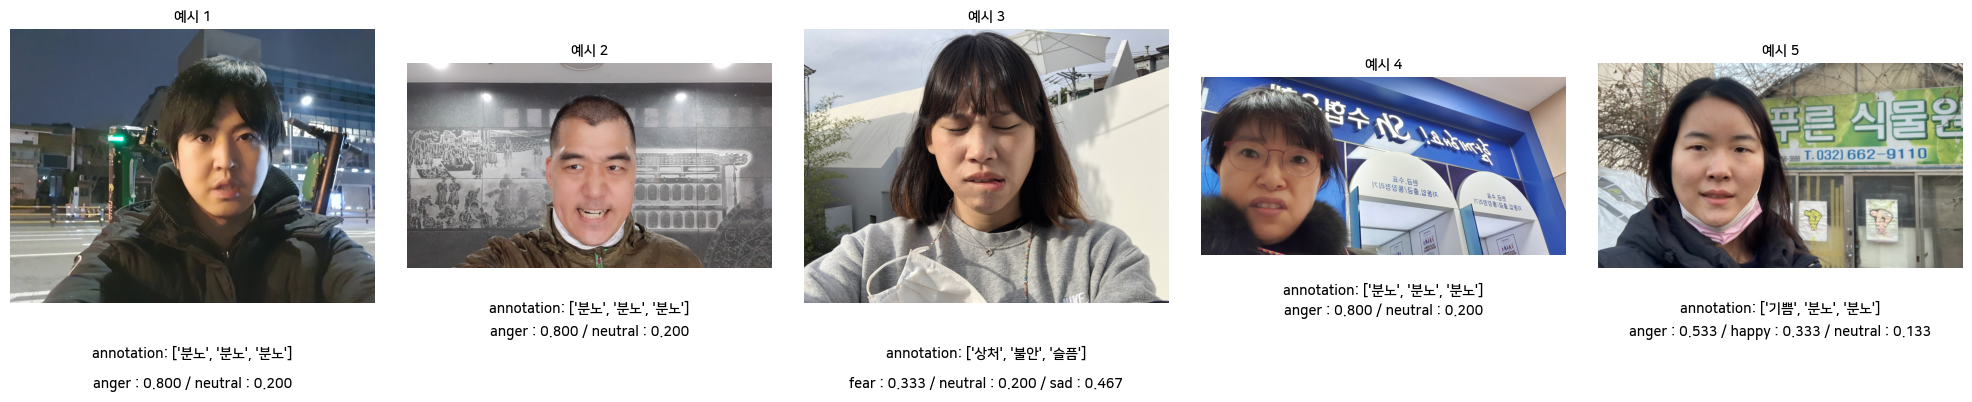

In [6]:
# Cell 6: (선택 사항) 샘플 이미지 시각화 실행
# 예시: train/anger 데이터의 샘플 5개 시각화
sample_data_for_display = []
json_fp_sample = os.path.join(EST_DATA_BASE_DIR, 'label_train', 'train_anger.json')
if os.path.isfile(json_fp_sample):
    try:
        with open(json_fp_sample, "r", encoding="euc-kr") as f:
            sample_data_for_display = json.load(f)
    except Exception as e:
        print(f"Error loading sample data for display from {json_fp_sample}: {e}")

if sample_data_for_display:
    print(f"\n== 샘플 5개: train/anger ({json_fp_sample}) ==")
    display_sample_images(
        data_items=sample_data_for_display,
        img_folder=os.path.join(img_dirs['train'], 'anger'),
        backbone_classes=BACKBONE_CLASSES,
        annotation_to_backbone_map=annotation_to_backbone_map,
        create_soft_label_func=create_soft_label,
        correct_image_orientation_func=correct_image_orientation,
        font_prop=FONT_PROP,
        num_samples=5
    )
else:
    print("Could not load sample data for display.")

In [ ]:
# Cell 7: 결과 DataFrame 저장
output_csv_path = "./output/04_softlabel_dataset.csv"
df.to_csv(output_csv_path, index=False)
print(f"Processed data saved to {output_csv_path}")

Processed data saved to 04_softlabel_dataset.csv
